# Implementación del modelo de ML


## Instalar librerías

In [1]:
# Instalar librerías necesarias
# Para el manejo y carga de datos
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
# Tratamiento de variables y creación de datasets.
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
# Implementación de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
# Importar grilla para prueba
from sklearn.model_selection import GridSearchCV
# Medir tiempos
import time
# Métrica
from sklearn.metrics import roc_auc_score




In [2]:
from catboost import CatBoostClassifier

In [3]:
# Modelos adicionales
"""
from catboost impoty CatBoostClassifier
from lightgbm import LGBMClassifier
"""


'\nfrom catboost impoty CatBoostClassifier\nfrom lightgbm import LGBMClassifier\n'

## Descargar datos a utilizar 

In [4]:
# Descargar los datos pertinentes
path = "C:/Users/josem/Documents/No country/"
data = "application_data_procesada.parquet"
parquet_table = pq.read_table(path + data)
df = parquet_table.to_pandas()
# O esta ruta
#df = pd.read_parquet('../DataSets/application_data_procesada.parquet')


In [5]:
# Mostrar las primeras filas
df.head(3)

,ID_CREDITO,OBJETIVO,TIPO_PAGO,GENERO,PROP_AUTO,PROP_INMUEBLE,CANTIDAD_HIJOS,INGRESO,MONTO_CREDITO,ANUALIDAD_PRESTAMO,...,CALIFICACION_REGION_CLIENTE_CIUDAD,DIA_SEMANA_SOLICITUD,HORA_SOLICITUD,DIRECCION_PERMANENTE_NO_DIRECCION_CONTACTO,DIRECCION_PERMANENTE_NO_DIRECCION_TRABAJO,DIRECCION_CONTACTO_NO_DIRECCION_TRABAJO,NO_VIVE_CIUDAD_REGISTRADA,NO_TRABAJA_CIUDAD_REGISTRADA,NO_VIVE_CIUDAD_DE_TRABAJO,TIPO_ORGANIZACION
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1,MONDAY,11,0,0,0,0,0,0,School
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2,MONDAY,9,0,0,0,0,0,0,Government


In [6]:
# Vistazo a todos los nombres de las columnas.
df.columns

Index(['ID_CREDITO', 'OBJETIVO', 'TIPO_PAGO', 'GENERO', 'PROP_AUTO',
       'PROP_INMUEBLE', 'CANTIDAD_HIJOS', 'INGRESO', 'MONTO_CREDITO',
       'ANUALIDAD_PRESTAMO', 'PRECIO_BIENES', 'TIPO_ACOMPAÑANTE',
       'TIPO_INGRESO', 'NIVEL_ESTUDIO', 'ESTADO_CIVIL', 'TIPO_VIVIENDA',
       'POBLACION_RELATIVA_REGION', 'EDAD_DIAS', 'DIAS_EMPLEADO',
       'DIAS_MODIF_REGISTRO', 'DIAS_MODIF_DOCUMENTO', 'TIENE_CELULAR',
       'TELEFONO_EMPLEO', 'TELEFONO_TRABAJO', 'ATIENDE_CELULAR',
       'TELEFONO_CASA', 'EMAIL', 'PROFESION', 'CANTIDAD_MIEMBROS_FAMILIA',
       'CALIFICACION_REGION_CLIENTE', 'CALIFICACION_REGION_CLIENTE_CIUDAD',
       'DIA_SEMANA_SOLICITUD', 'HORA_SOLICITUD',
       'DIRECCION_PERMANENTE_NO_DIRECCION_CONTACTO',
       'DIRECCION_PERMANENTE_NO_DIRECCION_TRABAJO',
       'DIRECCION_CONTACTO_NO_DIRECCION_TRABAJO', 'NO_VIVE_CIUDAD_REGISTRADA',
       'NO_TRABAJA_CIUDAD_REGISTRADA', 'NO_VIVE_CIUDAD_DE_TRABAJO',
       'TIPO_ORGANIZACION'],
      dtype='object')

In [7]:
# Algunos modelos funcionan mejor con el tipo snake_case (y me gusta más en minus)
def to_snake_case(col):
    col = col.replace(' ', '_')
    p = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', col)
    return re.sub('([a-z0-9])(A-Z)', r'\1_\2', p).lower()


In [8]:
# Aplicar la función definida previamente
df.columns = [to_snake_case(col) for col in df.columns]

Dado que queremos realizar distintos modelos, lo más recomendable es transformar cada uno de los datos para que todos los modelos puedan procesarlos fácilmente.
- Columnas numéricas: escalarlas con StandardScaler()
- Columnas dicotómicas: aplicar OneHotEncoder()
- Columnas categóricas con demasiadas categorías: es mejor aplicar codificación de etiquetas para no generar un gran número de columnas. 
- Columnas ordinales: aplicar una codificación ordinal.

Es recomendable realizar una lista con aquellas columnas que recibirán el mismo tratamiento para los modelos. Se excluyen las columnas de `ID_CREDITO` Y `OBJETIVO` porque la primera no agregará información al modelo y la segunda es nuestra variable objetivo.

In [9]:
# Columnas numéricas: columnas con valores numéricos y cero absolutos.
numerical_x = ['cantidad_hijos', 'ingreso', 'monto_credito', 'anualidad_prestamo', 'precio_bienes', 'edad_dias', 'dias_empleado', 'dias_modif_registro', 'dias_modif_documento',
                'cantidad_miembros_familia']

# Columnas ordinales: columnas cuyos valores dependen del orden. 
ordinal_x = ['nivel_estudio', 'calificacion_region_cliente', 'calificacion_region_cliente_ciudad']

# Lista de variables dicotómicas
dichotomic_x = ['genero', 'prop_auto', 'prop_inmueble', 'tiene_celular', 'telefono_empleo', 'telefono_trabajo', 'atiende_celular', 'telefono_casa','email',
                'direccion_permanente_no_direccion_contacto', 'direccion_permanente_no_direccion_trabajo', 'direccion_contacto_no_direccion_trabajo', 'no_vive_ciudad_registrada',
                'no_trabaja_ciudad_registrada', 'no_vive_ciudad_de_trabajo']

# Lista de variables categóricas
categorical_x = ['tipo_pago', 'tipo_acompañante', 'tipo_ingreso', 'estado_civil', 'tipo_vivienda', 'profesion', 'dia_semana_solicitud', 'tipo_organizacion']

# Corroborar que están todas las columnas: deben ser 36
len(numerical_x) + len(ordinal_x) + len(dichotomic_x) + len(categorical_x)

36

 Creo que no habría que meter la columna de `población_relativa_region` porque esa está escalada y no sé cómo escalarla con respecto a las demás.


Es recomendable obtener las principales medidas de distribución.

In [10]:
df.iloc[:,0:18].describe()

,id_credito,objetivo,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,poblacion_relativa_region,edad_dias
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.454517,3.692794e+05,0.013831,4363.988632
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000


In [11]:
# Mostrar describe de demás columnas
df.iloc[:,18:28].describe()

,dias_empleado,dias_modif_registro,dias_modif_documento,tiene_celular,telefono_empleo,telefono_trabajo,atiende_celular,telefono_casa,email
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,63815.045904,-4986.120328,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720
std,141275.766519,3522.886321,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307
min,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2760.000000,-7479.500000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,-1213.000000,-4504.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,-289.000000,-2010.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,365243.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# Mostrar describe de las columnas faltantes.
df.iloc[:,28:35].describe()

,cantidad_miembros_familia,calificacion_region_cliente,calificacion_region_cliente_ciudad,hora_solicitud,direccion_permanente_no_direccion_contacto,direccion_permanente_no_direccion_trabajo
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,2.152651,2.052463,2.031521,12.063419,0.015144,0.050769
std,0.910695,0.509034,0.502737,3.265832,0.122126,0.219526
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,10.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,12.000000,0.000000,0.000000
75%,3.000000,2.000000,2.000000,14.000000,0.000000,0.000000
max,20.000000,3.000000,3.000000,23.000000,1.000000,1.000000


In [13]:
df.iloc[:,35:40].describe()

,direccion_contacto_no_direccion_trabajo,no_vive_ciudad_registrada,no_trabaja_ciudad_registrada,no_vive_ciudad_de_trabajo
count,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.040659,0.078173,0.230454,0.179555
std,0.197499,0.268444,0.421124,0.383817
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [14]:
# Observar la cantidad y calidad de `días_empleado` tienen valores imposibles.
df.query('dias_empleado > 360000').iloc[:,18:19].describe()

,dias_empleado
count,55374.0
mean,365243.0
std,0.0
min,365243.0
25%,365243.0
50%,365243.0
75%,365243.0
max,365243.0


# Observaciones generales
- Tenemos alrededor de 24,826 valores objetivo.
- La cantidad de hijos (y por lo tanto los miembros de la familia) tienen valores atípicos.
- El ingreso también tiene valores atípicos.
- Los montos del crédito y las anualidades parecen estar mejor distribuidos. 
- Se recomienda cambiar los `DIAS_EMPLEADO` Y `EDAD_DIAS` de días a años en valores positivos.
- Se propone la eliminación de las columnas de `tiene_celular` y `atiende_celular` ya que son practicamente el 99% 
- La columna de `dias_empleado` tiene valores imposibles (empleado desde hace 1000 años). Podemos sustituir estos valores por la media o eliminar la columna. 
- La columna de género tiene tres categorías.

Es recomendable observar la distribución de las variables.

## Observar la distribución de los datos mediante histogramas

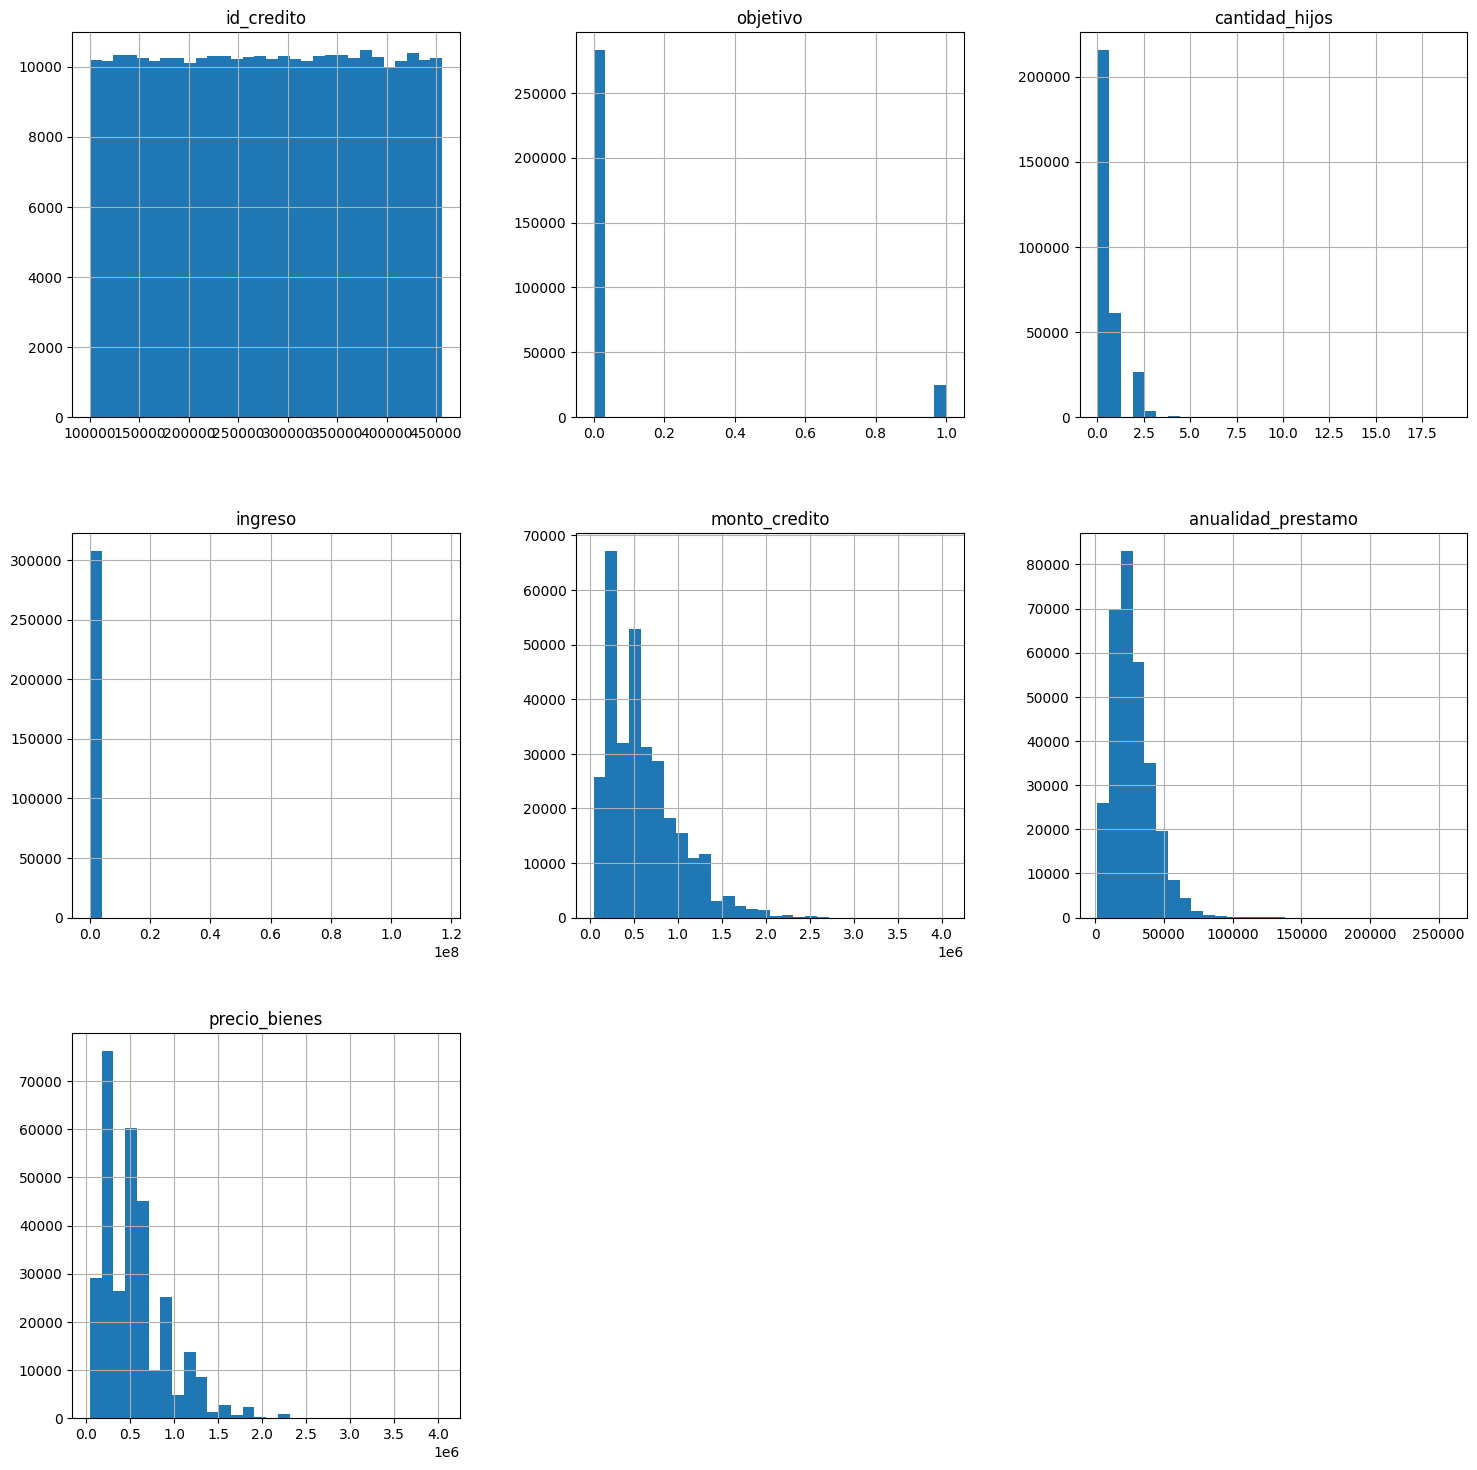

In [15]:
# Observaciones
df.iloc[:,0:15].hist(bins=30, figsize= (18,18))
plt.show()

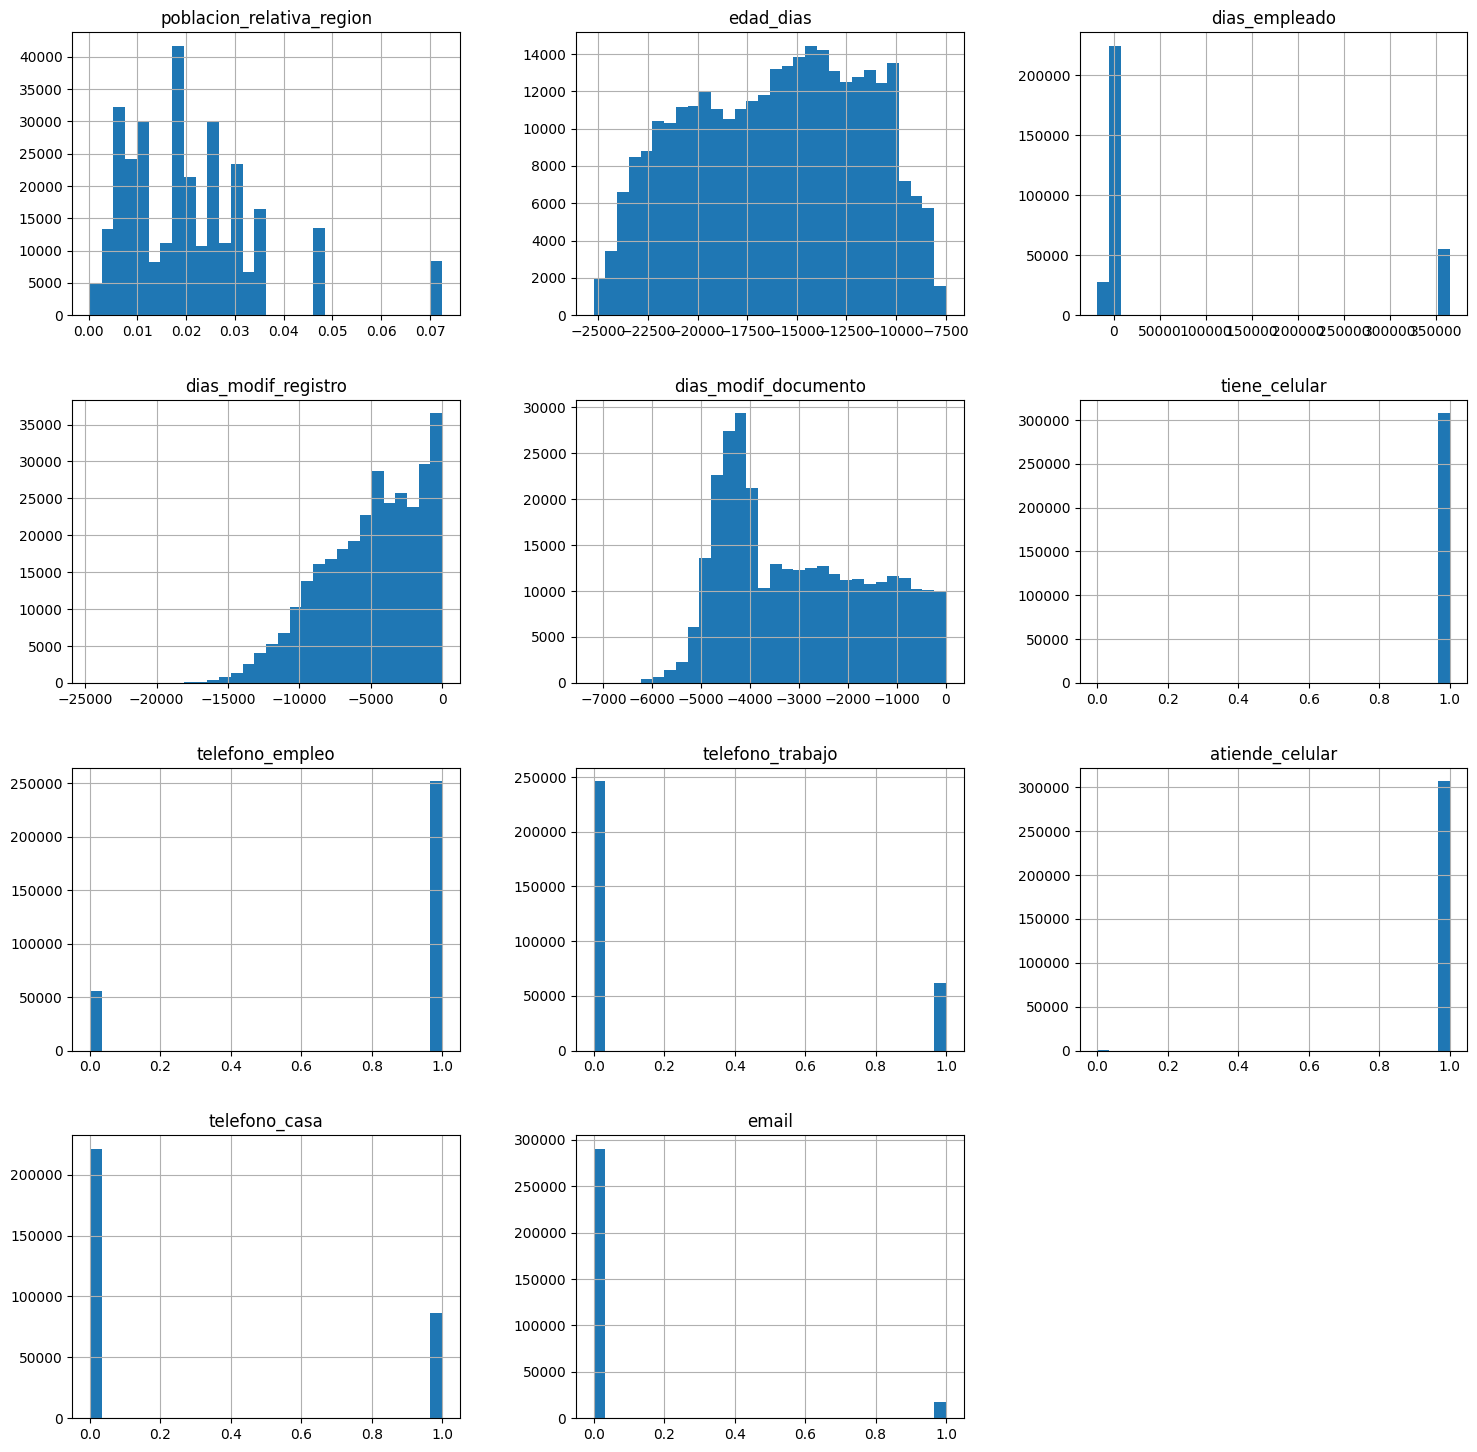

In [16]:
df.iloc[:,15:28].hist(bins=30, figsize= (18,18))
plt.show()

In [16]:
df.iloc[:,28:39].hist(bins=30, figsize= (18,18))
plt.show()

### Observaciones generales
- Casi todas las distribuciones de las variables numéricas tienen valores extremos. Esto es de esperarse ya que son variables relacionadas con el ingreso.
- Las variables dicotómicas conservan un valor de más de 70% en alguna de las dos categorías.



## Correlación lineal entre las variables

Idealmente podríamos observar un gráfico con las relaciones entre pares de variables. No obstante, la gran cantidad de datos hace que sea más viable simplemente calcular  la correlación lineal.

In [17]:
# Podemos observar el grado de correlación lineal entre variables.
(df[numerical_x].corr()).round(3)

,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,edad_dias,dias_empleado,dias_modif_registro,dias_modif_documento,cantidad_miembros_familia
cantidad_hijos,1.000,0.013,0.002,0.021,-0.002,0.331,-0.240,0.183,-0.028,0.879
ingreso,0.013,1.000,0.157,0.192,0.160,0.027,-0.064,0.028,0.009,0.016
monto_credito,0.002,0.157,1.000,0.770,0.987,-0.055,-0.067,0.010,-0.007,0.063
anualidad_prestamo,0.021,0.192,0.770,1.000,0.775,0.009,-0.104,0.039,0.011,0.076
precio_bienes,-0.002,0.160,0.987,0.775,1.000,-0.053,-0.065,0.012,-0.009,0.061
edad_dias,0.331,0.027,-0.055,0.009,-0.053,1.000,-0.616,0.332,0.273,0.279
dias_empleado,-0.240,-0.064,-0.067,-0.104,-0.065,-0.616,1.000,-0.210,-0.272,-0.234
dias_modif_registro,0.183,0.028,0.010,0.039,0.012,0.332,-0.210,1.000,0.102,0.173
dias_modif_documento,-0.028,0.009,-0.007,0.011,-0.009,0.273,-0.272,0.102,1.000,-0.021
cantidad_miembros_familia,0.879,0.016,0.063,0.076,0.061,0.279,-0.234,0.173,-0.021,1.000


### Observaciones generales

Las correlaciones lineales relativamente fuertes entre variables son:
- Monto de crédito y precio bienes: .987
- Anualidad y monto del préstamo: .770
- Precio de los bienes y su anualidad: .775

Lo anterior tiene sentido ya que los montos de los préstamos deben estar relacionados directamente con el monto de crédito y su anualidad.

## Ajuste de valores de columnas `dias_empleado`, `edad_dias`, `dias_modif_registro`, `dias_modif_documento`

<Axes: ylabel='Frequency'>

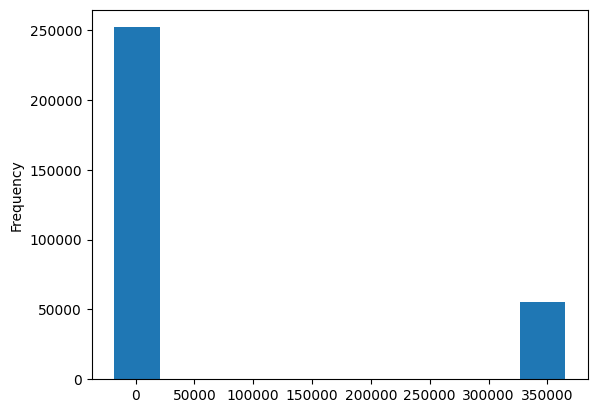

In [18]:
# Dias empleado
df.query('dias_empleado < 3700000')['dias_empleado'].plot(kind='hist')

<Axes: ylabel='Frequency'>

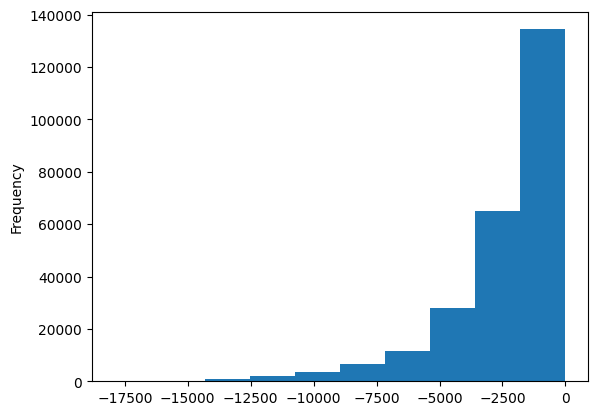

In [19]:
# Distribución de dias empleado sin valores atípicos
df.query('dias_empleado < 0')['dias_empleado'].plot(kind='hist')


### Observaciones generales

Los días empleado mayores a 365000 no son posibles, se recomienda sustituir valores extremos por la moda.

In [20]:
# Dada la distribución de los datos, lo mejor es sustituir los valores exrtremos por la moda de los valores correctos.
mode_dias_empleado = df.query("dias_empleado < 0")['dias_empleado'].mode()
# Sustituir los datos extremos por la moda
df['dias_empleado'] = np.where(df['dias_empleado']>365000, mode_dias_empleado, df['dias_empleado'])
# ELiminar la tercer categoría de genero de 6 columnas.
df['genero'] = np.where(df['genero']=="XNA", 'M', df['genero'])
# Convertir valores a años positivos
df['dias_modif_registro'] = df['dias_modif_registro'] / - 365
# Convertir valores a años positivos
df['dias_modif_documento'] = df['dias_modif_documento'] / -365
# Convertir `dias_empleado` a años positivos
df['dias_empleado'] = df['dias_empleado'] / -365
# Convertir edad en días a años positivos
df['edad_dias'] = df['edad_dias'] / - 365

In [21]:

########################## Redondear años
df[['dias_empleado', 'dias_modif_registro', 'dias_modif_documento', 'edad_dias']].describe()

,dias_empleado,dias_modif_registro,dias_modif_documento,edad_dias
count,307511.000000,307511.000000,307511.000000,307511.000000
mean,5.454418,13.660604,8.203294,43.936973
std,6.240124,9.651743,4.135481,11.956133
min,-0.000000,-0.000000,-0.000000,20.517808
25%,0.791781,5.506849,4.712329,34.008219
50%,3.323288,12.339726,8.915068,43.150685
75%,7.561644,20.491781,11.778082,53.923288
max,49.073973,67.594521,19.717808,69.120548


## Preprocesamiento de datos para implementación en los modelos


### Extraer variable objetivo del conjunto de datos.

In [24]:
# Extraer variable objetivo y dividir conjunto de datos para entrenamiento y prueba
x = df.drop(['objetivo', 'id_credito', 'poblacion_relativa_region', 'hora_solicitud'], axis = 1)
# Variable objetivo
y = df['objetivo']

### Dividir conjunto de entrenamiento del conjunto de prueba

In [25]:
# Conjunto de entrenamiento y prueba.
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, random_state=42)
# Confirmar forma de los nuevos data sets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((215257, 36), (92254, 36), (215257,), (92254,))

In [26]:
# Observar cuántos valores objetivo cayeron en cada dataset
y_train.sum(), y_test.sum()

(17412, 7413)

### Tratameinto de columnas numéricas

In [27]:
# Crear una instancia para el escalado de datos numéricos
scaler = StandardScaler()
# Ajustar y transformar el conjunto de entrenamiento
x_train[numerical_x] = scaler.fit_transform(x_train[numerical_x])
# Ajustar y transformar el conjunto de prueba 
x_test[numerical_x] = scaler.transform(x_test[numerical_x])
# Observar las transformaciones realizadas.
x_train.head(3)


,tipo_pago,genero,prop_auto,prop_inmueble,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,tipo_acompañante,...,calificacion_region_cliente,calificacion_region_cliente_ciudad,dia_semana_solicitud,direccion_permanente_no_direccion_contacto,direccion_permanente_no_direccion_trabajo,direccion_contacto_no_direccion_trabajo,no_vive_ciudad_registrada,no_trabaja_ciudad_registrada,no_vive_ciudad_de_trabajo,tipo_organizacion
127044,Cash loans,F,N,N,-0.578908,-0.104452,0.265362,2.751246,0.380564,Unaccompanied,...,1,1,WEDNESDAY,0,0,0,0,0,0,Services
281143,Cash loans,F,Y,Y,0.810571,-0.444539,-0.135161,-0.117939,-0.240303,Unaccompanied,...,2,2,MONDAY,0,0,0,0,0,0,Business Entity Type 3
199799,Cash loans,M,Y,Y,0.810571,0.533210,0.850846,0.038550,0.368391,Unaccompanied,...,2,2,THURSDAY,0,0,0,0,0,0,Self-employed


### Tratamiento de columnas dicotómicas


In [28]:
# Crear instancia de OHE
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Crear un dataframe con los valores bianrios del conjunto de entrenamiento
ohe_x = pd.DataFrame(ohe.fit_transform(x_train[dichotomic_x]), columns = dichotomic_x)
# crear un df con los valores binarios del conjunto prueba.
ohe_x_test = pd.DataFrame(ohe.transform(x_test[dichotomic_x]), columns = dichotomic_x)
# Concatenar con el dataframe original y eliminar las columnas repetidas (train)
x_train_ohe = pd.concat([x_train.drop(columns=dichotomic_x).reset_index(drop=True),ohe_x], axis=1)
# Concatenar con el dataframe original y eliminar las columnas repetidas (test)
x_test_ohe = pd.concat([x_test.drop(columns = dichotomic_x).reset_index(drop=True), ohe_x_test], axis=1)
# Observar primeras tres columnas del nuevo df 
x_test_ohe.head(3)


,tipo_pago,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,tipo_acompañante,tipo_ingreso,nivel_estudio,estado_civil,...,telefono_trabajo,atiende_celular,telefono_casa,email,direccion_permanente_no_direccion_contacto,direccion_permanente_no_direccion_trabajo,direccion_contacto_no_direccion_trabajo,no_vive_ciudad_registrada,no_trabaja_ciudad_registrada,no_vive_ciudad_de_trabajo
0,Cash loans,2.200051,0.363166,-0.332686,1.757459,-0.325520,Unaccompanied,Commercial associate,Secondary / secondary special,Married,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,Cash loans,-0.578908,0.745764,1.693274,1.503047,1.731864,Unaccompanied,Commercial associate,Higher education,Single / not married,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cash loans,-0.578908,0.320656,-0.259361,0.825647,-0.118564,Unaccompanied,Working,Secondary / secondary special,Married,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Verificar dimensiones
x_train_ohe.shape, x_test_ohe.shape

((215257, 36), (92254, 36))

### Implementar codificación ordinal en columnas categóricas.


In [30]:
# Juntas la lista de columnas categóricas.
cat_x = categorical_x + ordinal_x

In [31]:
ordinal = OrdinalEncoder()

ordinal_x = pd.DataFrame(ordinal.fit_transform(x_train[cat_x]), columns = cat_x)
ordinal_x_test = pd.DataFrame(ordinal.transform(x_test[cat_x]), columns = cat_x)

In [32]:
# COncatenar los dataframes a donde pertenecen.
x_train_processed = pd.concat([x_train_ohe.drop(columns = cat_x).reset_index(drop=True), ordinal_x], axis=1)
x_test_processed = pd.concat([x_test_ohe.drop(columns = cat_x).reset_index(drop=True), ordinal_x_test], axis=1)


## Implementación del modelo

In [33]:
# Crear una función para hacer distintos modelamientos
def modeling(instance, params, x_train, y_train, x_test, y_test):
    #Eliminate warnings if present
    import warnings
    warnings.filterwarnings("ignore")
    # Grid for to implement
    model_grid = GridSearchCV(instance, params, cv=5, scoring='roc_auc')
    # Training
    start = time.time()
    model_grid.fit(x_train, y_train)
    end = time.time()
    # Results from training
    print('Best AUC-ROC score in training set:', model_grid.best_score_)
    print('')
    print('Best Params:', model_grid.best_params_)
    print('')
    model_omens = model_grid.predict_proba(x_test)[:,1]

    spread = (end-start)

    model_roc = roc_auc_score(y_test, model_omens)

    print('AUC-ROC score in test set:', model_roc, '\n' ,'Time for training: {:.3}s'.format(spread))

    return model_grid.best_score_, model_roc, spread

### Modelo de Regresión Logística

In [34]:

log_params = {'penalty':['l1', 'l2', 'elasticnet']}
modeling(LogisticRegression(), log_params, x_train_processed, y_train, x_test_processed, y_test)


Best AUC-ROC score in training set: 0.6640976434710593

Best Params: {'penalty': 'l2'}

AUC-ROC score in test set: 0.6644746754466074 
 Time for training: 32.0s


(0.6640976434710593, 0.6644746754466074, 32.046162366867065)

In [35]:
"""
forest_params = {'n_estimators':[100, 110, 90],
                 'criterion':['gini', 'entropy'],
                 'class_weight':['balanced', None]}
RandomForestClassifier(random_state=42)

modeling(RandomForestClassifier(random_state=42), forest_params, x_train_processed, y_train, x_test_processed, y_test)
"""

"\nforest_params = {'n_estimators':[100, 110, 90],\n                 'criterion':['gini', 'entropy'],\n                 'class_weight':['balanced', None]}\nRandomForestClassifier(random_state=42)\n\nmodeling(RandomForestClassifier(random_state=42), forest_params, x_train_processed, y_train, x_test_processed, y_test)\n"

In [36]:
x_train_sin_ordinal = x_train_ohe.drop(cat_x, axis=1)

In [37]:
x_test_sin_ordinal = x_test_ohe.drop(cat_x, axis=1)

In [38]:
x_train_ohe.columns

Index(['tipo_pago', 'cantidad_hijos', 'ingreso', 'monto_credito',
       'anualidad_prestamo', 'precio_bienes', 'tipo_acompañante',
       'tipo_ingreso', 'nivel_estudio', 'estado_civil', 'tipo_vivienda',
       'edad_dias', 'dias_empleado', 'dias_modif_registro',
       'dias_modif_documento', 'profesion', 'cantidad_miembros_familia',
       'calificacion_region_cliente', 'calificacion_region_cliente_ciudad',
       'dia_semana_solicitud', 'tipo_organizacion', 'genero', 'prop_auto',
       'prop_inmueble', 'tiene_celular', 'telefono_empleo', 'telefono_trabajo',
       'atiende_celular', 'telefono_casa', 'email',
       'direccion_permanente_no_direccion_contacto',
       'direccion_permanente_no_direccion_trabajo',
       'direccion_contacto_no_direccion_trabajo', 'no_vive_ciudad_registrada',
       'no_trabaja_ciudad_registrada', 'no_vive_ciudad_de_trabajo'],
      dtype='object')

In [39]:

"""
kneigh_params = {'n_neighbors':[5],
                'weights':['uniform'],
                'leaf_size':[2],
                'algorithm':['ball_tree'],
                'p':[1,2]}

modeling(KNeighborsClassifier(), kneigh_params, x_train_sin_ordinal, y_train, x_test_sin_ordinal, y_test)
"""


"\nkneigh_params = {'n_neighbors':[5],\n                'weights':['uniform'],\n                'leaf_size':[2],\n                'algorithm':['ball_tree'],\n                'p':[1,2]}\n\nmodeling(KNeighborsClassifier(), kneigh_params, x_train_sin_ordinal, y_train, x_test_sin_ordinal, y_test)\n"

In [41]:
pip install catboost


  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/21/e2/2f35de12dbe85d0b2058dcf9b7e85819a05c77999415c26767e585000883/catboost-1.2.5-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/0b/f8/b65cdd2be32e442c4efe7b672f73c90b05eab5a7f3f4115efe181d432c60/plotly-5.22.0-py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/61/a1/6bb0cbebefb23641f068bb58a2bc56da9beb2b1c550242e3c540b37698f3/tenacity-8.3.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ------------------------------------


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
""""""
lasso_params = {'alpha':[1,3,5,16,100]}

modeling(Lasso(random_state= 42), lasso_params, x_train_processed, y_train, x_test_processed, y_test)
"""

SyntaxError: incomplete input (1364252912.py, line 5)

In [ ]:
lgbm_params = {'learning_rate':[float(i) for i in list(np.linspace(.03,.125,4))],
               'class_weight':['balanced','is_unbalanced', 'scale_pos_weight'],
               'n_estimators':[100,200],
               'num_leaves':[int(x) for x in np.linspace(31,39,4)]}
modeling = 